In [1]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import log_loss, classification_report
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.model_selection import StratifiedKFold

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import Pool, CatBoostClassifier

from tqdm.auto import tqdm

import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('./open/train.csv', index_col='index').reset_index(drop=True)
test = pd.read_csv('./open/test.csv', index_col='index').reset_index(drop=True)

In [3]:
# train = train.drop_duplicates().reset_index(drop=True)

In [4]:
print(train.shape)
print(test.shape)

(26457, 19)
(10000, 18)


In [5]:
train['UNEMPLOYED'] = train['DAYS_EMPLOYED'].map(lambda x: 1 if x>0 else 0).astype('object')
train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED'].map(lambda x: -1 if x>0 else x)

test['UNEMPLOYED'] = test['DAYS_EMPLOYED'].map(lambda x: 1 if x>0 else 0).astype('object')
test['DAYS_EMPLOYED'] = test['DAYS_EMPLOYED'].map(lambda x: -1 if x>0 else x)

In [6]:
train['employ_by_birth'] = train['DAYS_EMPLOYED'] / train['DAYS_BIRTH']
test['employ_by_birth'] = test['DAYS_EMPLOYED'] / test['DAYS_BIRTH']

In [7]:
train['begin_by_employ'] = train['begin_month'] / train['DAYS_EMPLOYED']
test['begin_by_employ'] = test['begin_month'] / test['DAYS_EMPLOYED']

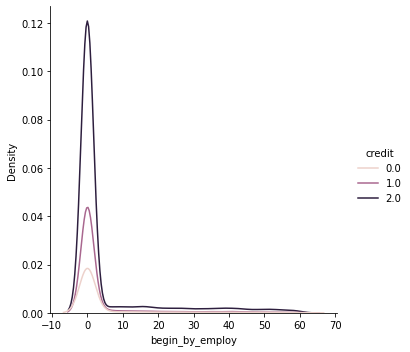

In [8]:
sns.displot(
    data= train,
    x='begin_by_employ',
    hue='credit',
    kind='kde'
)

## Encoding

In [9]:
train['occyp_type'] = train['occyp_type'].fillna('None')
test['occyp_type'] = test['occyp_type'].fillna('None')

In [10]:
train['work_tm']=-(train['DAYS_EMPLOYED'])//365
test['work_tm']=-(test['DAYS_EMPLOYED'])//365

In [11]:
train.loc[(train['occyp_type']=='Cleaning staff') | (train['occyp_type']=='Cooking staff') | (train['occyp_type']=='Drivers') | (train['occyp_type']=='Laborers') | (train['occyp_type']=='Low-skill Laborers') | (train['occyp_type']=='Security staff') | (train['occyp_type']=='Waiters/barmen staff'),'occyp_group']='Laborwk'
train.loc[(train['occyp_type']=='Accountants') | (train['occyp_type']=='Core staff') | (train['occyp_type']=='HR staff') | (train['occyp_type']=='Medicine staff') | (train['occyp_type']=='Private service staff') | (train['occyp_type']=='Realty agents') | (train['occyp_type']=='Sales staff') | (train['occyp_type']=='Secretaries'),'occyp_group']='officewk'
train.loc[(train['occyp_type']=='Managers') | (train['occyp_type']=='High skill tech staff') | (train['occyp_type']=='IT staff'),'occyp_group']='hightecwk'

test.loc[(test['occyp_type']=='Cleaning staff') | (test['occyp_type']=='Cooking staff') | (test['occyp_type']=='Drivers') | (test['occyp_type']=='Laborers') | (test['occyp_type']=='Low-skill Laborers') | (test['occyp_type']=='Security staff') | (test['occyp_type']=='Waiters/barmen staff'),'occyp_group']='Laborwk'
test.loc[(test['occyp_type']=='Accountants') | (test['occyp_type']=='Core staff') | (test['occyp_type']=='HR staff') | (test['occyp_type']=='Medicine staff') | (test['occyp_type']=='Private service staff') | (test['occyp_type']=='Realty agents') | (test['occyp_type']=='Sales staff') | (test['occyp_type']=='Secretaries'),'occyp_group']='officewk'
test.loc[(test['occyp_type']=='Managers') | (test['occyp_type']=='High skill tech staff') | (test['occyp_type']=='IT staff'),'occyp_group']='hightecwk'

In [12]:
train['occyp_group'] = train['occyp_group'].fillna('None')
test['occyp_group'] = test['occyp_group'].fillna('None')

In [13]:
train['reality_car'] = train['reality'] + '-' + train['car']
test['reality_car'] = test['reality'] + '-' + test['car']

In [14]:
reality_car_type = ['N-N', 'N-Y', 'Y-N', 'Y-Y']

train['reality_car'] = train['reality_car'].map(lambda x: reality_car_type.index(x))
test['reality_car'] = test['reality_car'].map(lambda x: reality_car_type.index(x)) 

In [15]:
train['phone_total'] = train['FLAG_MOBIL'] + train['work_phone'] + train['phone']
test['phone_total'] = test['FLAG_MOBIL'] + test['work_phone'] + test['phone']

In [16]:
CATEGORY_COL = [col for col in train.columns if train[col].dtype == 'object']
# CATEGORY_COL = ['gender', 'car', 'reality', 'email', 'family_type', 'house_type', 'UNEMPLOYED', 'income_edu', 'income_occyp', 'occyp_edu']
# CATEGORY_COL = ['gender', 'car', 'reality', 'income_edu', 'UNEMPLOYED', 'family_type', 'house_type', 'income_type', 'edu_type', 'family_house']
NUMERIC_COL = [col for col in train.columns if train[col].dtype != 'object' and col!='credit']

FEATURES = CATEGORY_COL + NUMERIC_COL

TARGET = train['credit']

train = train[FEATURES]
test = test[FEATURES]

In [17]:
from sklearn.compose import make_column_transformer

column_trans = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'), CATEGORY_COL),
    remainder='passthrough'
)

train = column_trans.fit_transform(train)
train = pd.DataFrame(train, columns=column_trans.get_feature_names())

test = pd.DataFrame(column_trans.transform(test), columns=column_trans.get_feature_names())

In [18]:
print(train.shape)
print(test.shape)

(26457, 67)
(10000, 67)


In [37]:
len(column_trans.get_feature_names()[:-15])

52

In [46]:
param = {'boosting_type':'gbdt',
         'max_depth': -1, 
         'num_leaves': 64,
         'objective': 'multi-class',
         'n_estimators': 2000, 
         'learning_rate': 0.05, 
         'subsample': 0.8, 
         'colsample_bytree': 0.8,
         'categorical_feature': [i for i in range(53)]
        
        }

In [47]:
oof_lgb = np.zeros((len(train),3))
lgb_pred = np.zeros((len(test),3))
feature_importance_df = pd.DataFrame()

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold_, (trn_idx, val_idx) in enumerate(skf.split(train, TARGET)):
    print("\nfold num_: {}".format(fold_))
    y_train, y_valid = TARGET[trn_idx], TARGET[val_idx]
    X_train, X_valid = train.iloc[trn_idx], train.iloc[val_idx]
    
    clf = LGBMClassifier(**param)
    clf.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_valid, y_valid)], 
            early_stopping_rounds=100,
            verbose=100)
    
    oof_lgb[val_idx] = clf.predict_proba(X_valid, num_iteration=clf.best_iteration_)    
    lgb_pred += clf.predict_proba(test, num_iteration=clf.best_iteration_)

lgb_pred /= 5    
print('\nCross Validation Is Complete')                           
print("CV score: {:<8.5f}".format(log_loss(TARGET, oof_lgb)))


fold num_: 0
Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.636873	valid_1's multi_logloss: 0.748018
[200]	training's multi_logloss: 0.546861	valid_1's multi_logloss: 0.730203
[300]	training's multi_logloss: 0.477561	valid_1's multi_logloss: 0.724632
[400]	training's multi_logloss: 0.422071	valid_1's multi_logloss: 0.72454
Early stopping, best iteration is:
[349]	training's multi_logloss: 0.448624	valid_1's multi_logloss: 0.723007

fold num_: 1
Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.630117	valid_1's multi_logloss: 0.758945
[200]	training's multi_logloss: 0.535791	valid_1's multi_logloss: 0.743905
[300]	training's multi_logloss: 0.470545	valid_1's multi_logloss: 0.741582
[400]	training's multi_logloss: 0.415664	valid_1's multi_logloss: 0.74411
Early stopping, best iteration is:
[306]	training's multi_logloss: 0.466628	valid_1's multi_logloss: 0.74132

fold num_: 2
Training until va

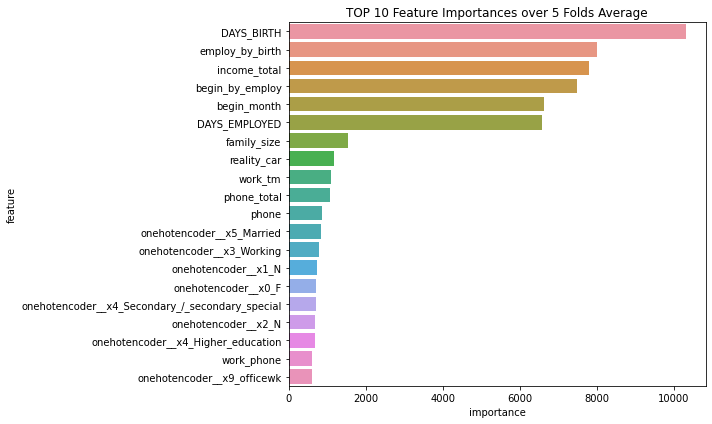

In [48]:
feature_importance = pd.DataFrame({'feature':clf.feature_name_, 'importance':clf.feature_importances_})

plt.figure(figsize=(10,6))
sns.barplot(x='importance', 
            y='feature', 
            data=feature_importance.sort_values(by="importance", ascending=False).reset_index()[:20])

plt.title('TOP 10 Feature Importances over 5 Folds Average')
plt.tight_layout()

In [198]:
# result = permutation_importance(clf, X_train, y_train, n_repeats=10,
#                                 random_state=42, n_jobs=-1)
# sorted_idx = result.importances_mean.argsort()

# fig, ax = plt.subplots()
# ax.boxplot(result.importances[sorted_idx].T,
#            vert=False, labels=X_train.columns[sorted_idx])
# ax.set_title("Permutation Importances (train set)")
# fig.tight_layout()
# plt.show()

In [136]:
submit = pd.read_csv('./open/sample_submission.csv')

submit.iloc[:, 1:] = (lgb_pred+cat_pred)/2
submit.to_csv('./lgb_cat.csv', index=False)

In [98]:
lgb_pred

array([[0.05130736, 0.08304998, 0.86564267],
       [0.19785673, 0.23351888, 0.56862439],
       [0.03122761, 0.07466962, 0.89410278],
       ...,
       [0.02839304, 0.09020285, 0.88140411],
       [0.10593975, 0.23092058, 0.66313967],
       [0.07574578, 0.19198286, 0.73227136]])

In [101]:
# model = CatBoostClassifier(loss_function='MultiClass', 
#                            depth = -1,
#                            early_stopping_rounds=100,
#                            task_type="GPU",
#                            random_state=42,
#                            learning_rate=0.05,
#                            iterations=5000)

# skf = StratifiedKFold(n_splits=5, random_state=55, shuffle=True)


# oof_cat = np.zeros((len(train), 3))
# cat_pred = np.zeros((len(test), 3))


# for idx, (trn_idx, val_idx) in enumerate(skf.split(train, train['credit'])):
#     y_train, y_valid = train.iloc[trn_idx][TARGET], train.iloc[val_idx][TARGET]
#     X_train, X_valid = train.iloc[trn_idx][FEATURES], train.iloc[val_idx][FEATURES]
    
#     _train = Pool(X_train, label=y_train)
#     _valid = Pool(X_valid, label=y_valid)
    
#     print( "\nFold ", idx)
#     fit_model = model.fit(_train,
#                           eval_set=_valid,
#                           use_best_model=True,
#                           verbose=200
#                          )
#     pred = fit_model.predict_proba(X_valid)
#     print( "  Log loss = ", log_loss(y_valid, pred) )
#     oof_cat[val_idx] = pred
#     cat_pred += fit_model.predict_proba(test[FEATURES])
# cat_pred /= 5
# print("CV score: {:<8.5f}".format(log_loss(train[TARGET], oof_cat)))

In [49]:
from xgboost import XGBClassifier

xgb_params={'learning_rate':0.05,
            'booster': 'gbtree',
            'n_estimators': 2000,
            'max_depth':10,
            'objective':'multi:softprob',
            'num_class':3,
            'subsample':0.8,
            'colsample_bytree':0.8,
            'random_state':42,
            'tree_method':'gpu_hist',
            'gpu_id': 0,
            'n_jobs': -1,
            'predictor':'gpu_predictor'}

In [52]:
oof_xgb = np.zeros((len(train), 3))
xgb_pred = np.zeros((len(test), 3))

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

for fold_, (trn_idx, val_idx) in enumerate(skf.split(train, TARGET)):
    print("\nfold num_: {}".format(fold_))
    y_train, y_valid = TARGET[trn_idx], TARGET[val_idx]
    X_train, X_valid = train.iloc[trn_idx], train.iloc[val_idx]

    clf = XGBClassifier(**xgb_params)
    clf.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_valid, y_valid)], 
            eval_metric= 'mlogloss',
            early_stopping_rounds=100,
            verbose=100
           )

    oof_xgb[val_idx] = clf.predict_proba(X_valid, ntree_limit=clf.best_iteration)    
    xgb_pred += clf.predict_proba(test, ntree_limit=clf.best_iteration)

xgb_pred /= 5  
print(f'\nSEED: {seed}, Cross Validation Is Complete')                           
print("CV score: {:<8.5f}".format(log_loss(TARGET, oof_xgb)))


fold num_: 0
[0]	validation_0-mlogloss:1.07328	validation_1-mlogloss:1.07578
[100]	validation_0-mlogloss:0.58383	validation_1-mlogloss:0.75005
[200]	validation_0-mlogloss:0.45287	validation_1-mlogloss:0.72843
[300]	validation_0-mlogloss:0.36219	validation_1-mlogloss:0.72591
[365]	validation_0-mlogloss:0.31363	validation_1-mlogloss:0.73150

fold num_: 1
[0]	validation_0-mlogloss:1.07319	validation_1-mlogloss:1.07599
[100]	validation_0-mlogloss:0.57700	validation_1-mlogloss:0.74919
[200]	validation_0-mlogloss:0.45281	validation_1-mlogloss:0.72652
[300]	validation_0-mlogloss:0.36130	validation_1-mlogloss:0.72437
[371]	validation_0-mlogloss:0.31173	validation_1-mlogloss:0.72896

fold num_: 2
[0]	validation_0-mlogloss:1.07351	validation_1-mlogloss:1.07560
[100]	validation_0-mlogloss:0.57952	validation_1-mlogloss:0.74061
[200]	validation_0-mlogloss:0.44782	validation_1-mlogloss:0.72190
[300]	validation_0-mlogloss:0.35847	validation_1-mlogloss:0.72135
[333]	validation_0-mlogloss:0.33274	vali

In [51]:
# cv_list = []

# xgb_final_oof_train = np.zeros((len(train), 3))
# xgb_final_oof_test = np.zeros((len(test), 3))

# n_seeds = 3

# for _ in tqdm(range(n_seeds) ):
#     seed = np.random.randint(10000)

#     oof_xgb = np.zeros((len(train), 3))
#     xgb_pred = np.zeros((len(test), 3))
    
#     skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    
#     for fold_, (trn_idx, val_idx) in enumerate(skf.split(train, TARGET)):
#         print("\nfold num_: {}".format(fold_))
#         y_train, y_valid = TARGET[trn_idx], TARGET[val_idx]
#         X_train, X_valid = train.iloc[trn_idx], train.iloc[val_idx]

#         clf = XGBClassifier(**xgb_params)
#         clf.fit(X_train, y_train, 
#                 eval_set=[(X_train, y_train), (X_valid, y_valid)], 
#                 eval_metric= 'mlogloss',
#                 early_stopping_rounds=100,
#                 verbose=100
#                )

#         oof_xgb[val_idx] = clf.predict_proba(X_valid, ntree_limit=clf.best_iteration)    
#         xgb_pred += clf.predict_proba(test, ntree_limit=clf.best_iteration)
    
#     xgb_pred /= 5  
#     xgb_final_oof_train += oof_xgb
#     xgb_final_oof_test += xgb_pred
#     cv_list.append(log_loss(TARGET, oof_xgb))
#     print(f'\nSEED: {seed}, Cross Validation Is Complete')                           
#     print("CV score: {:<8.5f}".format(log_loss(TARGET, oof_xgb)))
                   
# xgb_final_oof_train /= n_seeds
# xgb_final_oof_test /= n_seeds


# print('\nEnsemble Is Complete')                           
# print("CV score: {:<8.5f}".format(log_loss(TARGET, xgb_final_oof_train)))


fold num_: 0
[0]	validation_0-mlogloss:1.07328	validation_1-mlogloss:1.07578
[100]	validation_0-mlogloss:0.58383	validation_1-mlogloss:0.75005
[200]	validation_0-mlogloss:0.45287	validation_1-mlogloss:0.72843
[300]	validation_0-mlogloss:0.36219	validation_1-mlogloss:0.72591
[366]	validation_0-mlogloss:0.31311	validation_1-mlogloss:0.73158



NameError: name 'oof_xgb' is not defined

In [110]:
print("CV score: {:<8.5f}".format(log_loss(train[TARGET], xgb_final_oof_train)))

CV score: 0.70573 


In [105]:
# oof_xgb = np.zeros((len(train),3))
# xgb_pred = np.zeros((len(test),3))

# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=55)

# for fold_, (trn_idx, val_idx) in enumerate(skf.split(train, train['credit'])):
#     print("\nfold num_: {}".format(fold_))
#     y_train, y_valid = train.iloc[trn_idx][TARGET], train.iloc[val_idx][TARGET]
#     X_train, X_valid = train.iloc[trn_idx][FEATURES], train.iloc[val_idx][FEATURES]
    
#     clf = XGBClassifier(**xgb_params)
#     clf.fit(X_train, y_train, 
#             eval_set=[(X_train, y_train), (X_valid, y_valid)], 
#             eval_metric= 'mlogloss',
#             early_stopping_rounds=100,
#             verbose=100
#            )
    
#     oof_xgb[val_idx] = clf.predict_proba(X_valid, ntree_limit=clf.best_iteration)    
#     xgb_pred += clf.predict_proba(test[FEATURES], ntree_limit=clf.best_iteration)

# xgb_pred /= 5    
# print('\nCross Validation Is Complete')                           
# print("CV score: {:<8.5f}".format(log_loss(train[TARGET], oof_xgb)))

In [214]:
clf.feature_importances_

array([0.0165083 , 0.01918124, 0.01560014, 0.01608433, 0.0209005 ,
       0.02117451, 0.        , 0.01581427, 0.01486951, 0.01643497,
       0.01649488, 0.03054534, 0.01745131, 0.01664204, 0.01532006,
       0.01546978, 0.01579339, 0.01537528, 0.0154077 , 0.01529752,
       0.01832022, 0.01595206, 0.01732962, 0.01648411, 0.01851191,
       0.02040002, 0.01650986, 0.02057905, 0.01862492, 0.02084663,
       0.01714407, 0.01872227, 0.01814236, 0.0190292 , 0.01689574,
       0.01896947, 0.02003352, 0.01722784, 0.01726484, 0.01616623,
       0.01810108, 0.01699464, 0.0179424 , 0.01673357, 0.02029702,
       0.02187584, 0.01808022, 0.02316559, 0.02020494, 0.030773  ,
       0.01642661, 0.01797531, 0.01617133, 0.01806406, 0.01775138,
       0.01592396], dtype=float32)

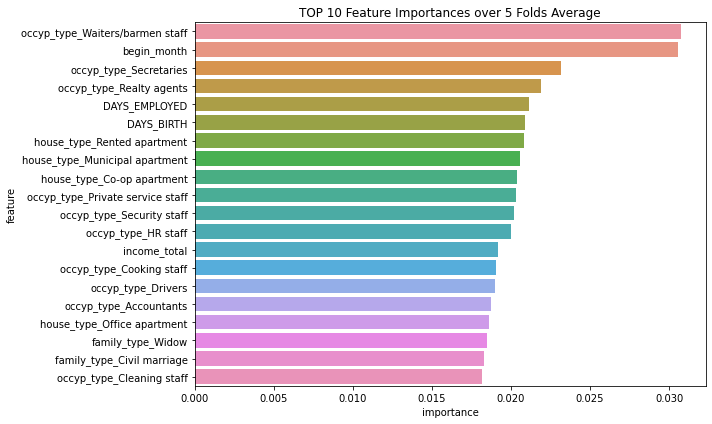

In [215]:
feature_importance = pd.DataFrame({'feature':FEATURES, 'importance':clf.feature_importances_})

plt.figure(figsize=(10,6))
sns.barplot(x='importance', 
            y='feature', 
            data=feature_importance.sort_values(by="importance", ascending=False).reset_index()[:20])

plt.title('TOP 10 Feature Importances over 5 Folds Average')
plt.tight_layout()

In [212]:
submit = pd.read_csv('./open/sample_submission.csv')

submit.iloc[:, 1:] = (lgb_pred+xgb_pred)/2
submit.to_csv('./0413_2_ensemble.csv', index=False)

In [111]:
submit = pd.read_csv('./open/sample_submission.csv')

submit.iloc[:, 1:] = (xgb_final_oof_test)
submit.to_csv('./0414_xgb_pred.csv', index=False)

In [112]:
submit

,index,0,1,2
0,26457,0.053051,0.078562,0.868387
1,26458,0.220986,0.217915,0.561100
2,26459,0.040278,0.082406,0.877316
3,26460,0.134527,0.126587,0.738885
4,26461,0.067004,0.158697,0.774299
...,...,...,...,...
9995,36452,0.118967,0.239116,0.641917
9996,36453,0.204041,0.318282,0.477677
9997,36454,0.019155,0.057008,0.923837
9998,36455,0.108617,0.222395,0.668988
